In [1]:
# SHAP Interpretation


In [21]:
import warnings, numpy as np, pandas as pd, shap, joblib
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
shap.initjs()

DATA_PATH = Path("../data/stroke_clean.csv")
ART_DIR  = Path("../artifacts"); ART_DIR.mkdir(exist_ok=True)


In [22]:
df = pd.read_csv(DATA_PATH)
df["stroke"] = df["stroke"].astype(int)

# Same feature selection I used Modeling Stage, i.e 02_Modeling...file
selected_feats = ["age","hypertension","heart_disease","avg_glucose_level","bmi","smoking_status"]
target = "stroke"
df = df[selected_feats + [target]].copy()

# simple interactions (as in modeling
df["age_bmi_interaction"] = df["age"] * df["bmi"]
df["age_glucose_ratio"]   = df["avg_glucose_level"] / (df["age"] + 1)

# normalize smoking text & flag unknown
df["smoking_status"] = df["smoking_status"].astype(str).str.lower().fillna("unknown")
df["smoking_known"]  = (df["smoking_status"] != "unknown").astype(int)

num_features = ["age","avg_glucose_level","bmi","age_bmi_interaction","age_glucose_ratio"]
cat_features = ["smoking_status","smoking_known"]

X = df[num_features + cat_features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_split = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)


In [23]:
# // Recreate Preprocessing
pre_num = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler",  Standardized := StandardScaler())])
pre_cat = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                    ("ohe",     OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer([
    ("num", pre_num, num_features),
    ("cat", pre_cat, cat_features)
])

def feature_names_after_preprocess(preprocess, X_sample):
    preprocess.fit(X_sample)  # fit on training split
    num_names = np.array(num_features)
    cat_names = preprocess.named_transformers_["cat"]["ohe"].get_feature_names_out(cat_features)
    return np.concatenate([num_names, cat_names])


In [24]:
logit_path = ART_DIR/"logit_balanced.pkl"
xgb_path   = ART_DIR/"xgb_tuned.pkl"   # from 02 if you saved it

try:
    logit = joblib.load(logit_path)
    print("Loaded saved Logistic pipeline.")
except:
    logit = Pipeline([
        ("pre", preprocess),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear")),
    ])
    logit.fit(X_train, y_train)
    joblib.dump(logit, logit_path)
    print("Trained & saved lightweight Logistic (balanced).")

try:
    xgb_tuned = joblib.load(xgb_path)
    print("Loaded saved XGB pipeline.")
except:
    # light XGB (no CV) for SHAP illustration if you didn't save tuned one
    neg, pos = int((y_train==0).sum()), int((y_train==1).sum())
    spw = neg/max(pos,1)
    xgb_tuned = Pipeline([
        ("pre", preprocess),
        ("clf", XGBClassifier(
            n_estimators=400, max_depth=4, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, gamma=0.3,
            reg_lambda=1.0, random_state=42, n_jobs=-1,
            eval_metric="logloss", scale_pos_weight=spw
        ))
    ])
    xgb_tuned.fit(X_train, y_train)
    joblib.dump(xgb_tuned, xgb_path)
    print("Trained & saved lightweight XGB for SHAP.")


Loaded saved Logistic pipeline.
Loaded saved XGB pipeline.


In [25]:
# use the fitted preprocess from the pipelines:
pre_fitted = logit.named_steps["pre"]  # both pipelines share the same structure

Xtr_enc = pre_fitted.transform(X_train)
Xte_enc = pre_fitted.transform(X_test)

# ensure dense for SHAP if sparse
if hasattr(Xtr_enc, "toarray"):
    Xtr_enc = Xtr_enc.toarray()
    Xte_enc = Xte_enc.toarray()

feat_names = feature_names_after_preprocess(preprocess, X_train)
len(feat_names), Xtr_enc.shape, Xte_enc.shape


(11, (4088, 11), (1022, 11))

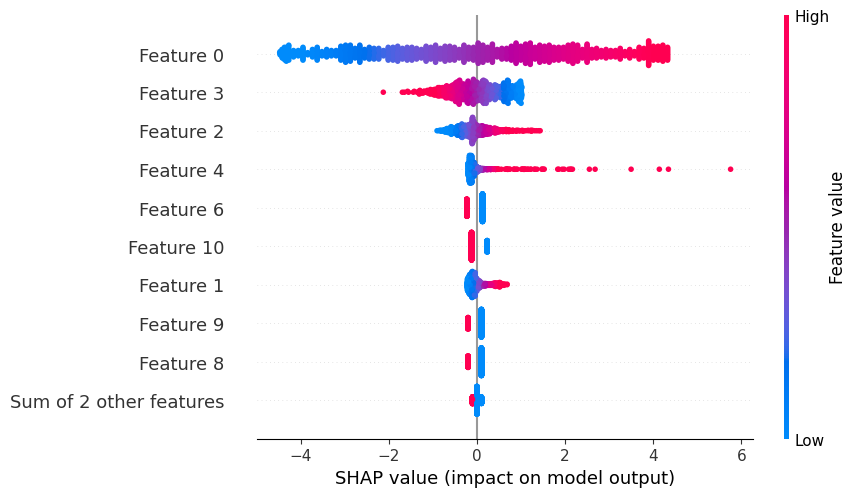

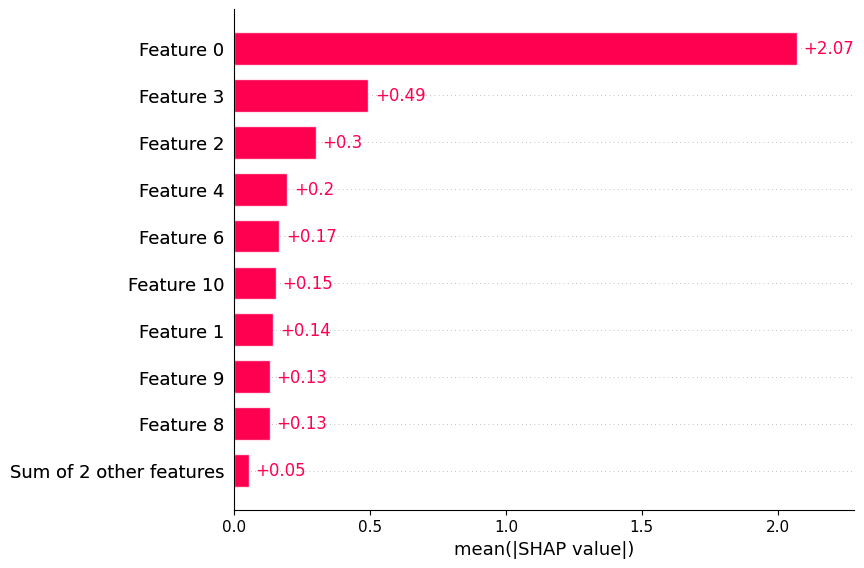

Logit high-risk prob: 0.9468736279558263 low-risk prob: 0.0064130292185126244


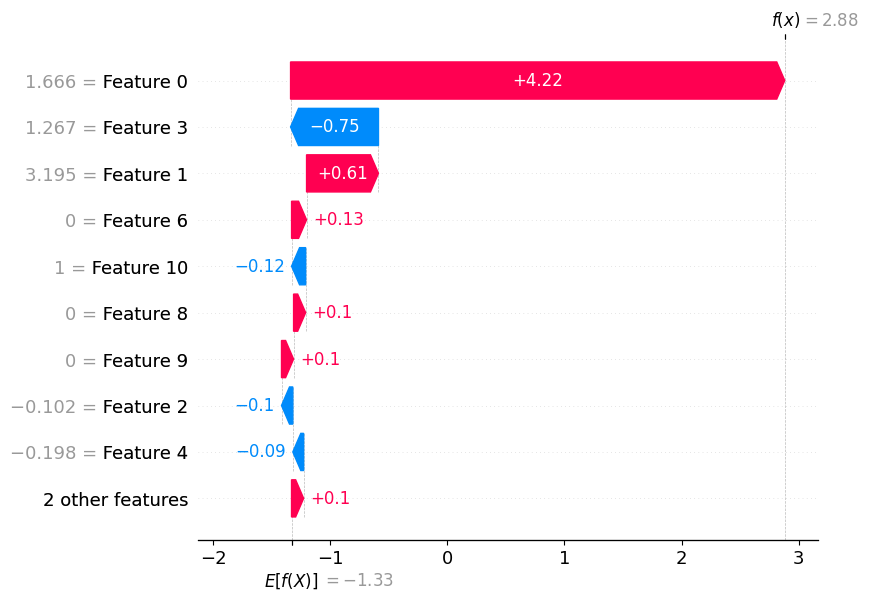

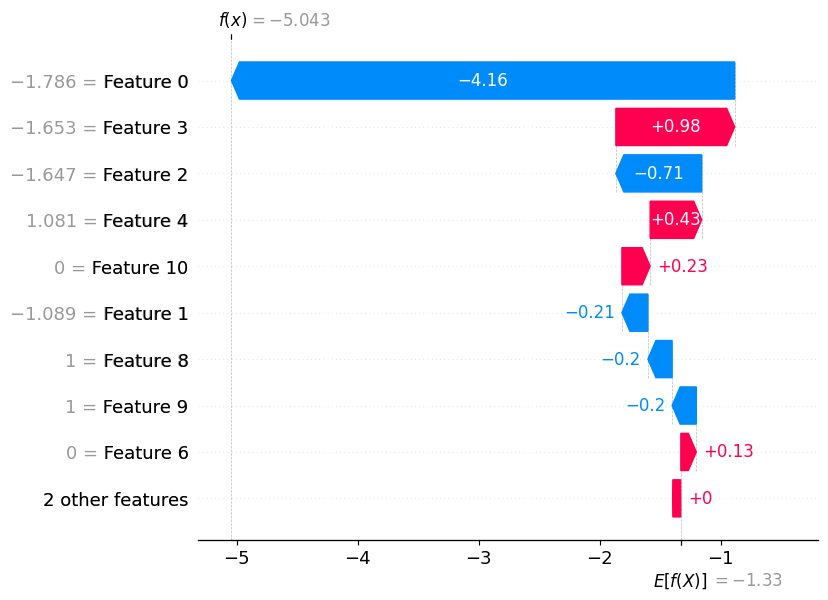

In [26]:
# For Logistic Regression

import numpy as np, shap

# --- use encoded train/test from your pipeline ---
# Xtr_enc, Xte_enc = pre_fitted.transform(X_train), pre_fitted.transform(X_test)
if hasattr(Xtr_enc, "toarray"):  # OneHot often yields sparse matrices
    Xtr_enc = Xtr_enc.toarray()
    Xte_enc = Xte_enc.toarray()

# small background for masker
bg_idx = np.random.default_rng(42).choice(Xtr_enc.shape[0], size=min(1000, Xtr_enc.shape[0]), replace=False)
background = Xtr_enc[bg_idx]

# build a masker (replaces feature_dependence="independent")
masker = shap.maskers.Independent(background)

# use the *fitted* LR estimator from your pipeline
logit_est = logit.named_steps["clf"]

# modern API: Explainer picks LinearExplainer under-the-hood for LR
lin_exp = shap.Explainer(logit_est, masker)
sv_logit = lin_exp(Xte_enc)  # returns shap.Explanation

# Global: beeswarm + bar
shap.plots.beeswarm(sv_logit, show=True)          # replaces summary_plot(..., plot_type="dot")
shap.plots.bar(sv_logit, show=True)               # mean|SHAP| bar plot

# Local: pick high-risk and low-risk examples
probs_logit = logit.predict_proba(X_test)[:, 1]
hi_idx = int(np.argmax(probs_logit))
lo_idx = int(np.argmin(probs_logit))

print("Logit high-risk prob:", probs_logit[hi_idx], "low-risk prob:", probs_logit[lo_idx])

shap.plots.waterfall(sv_logit[hi_idx], show=True)
shap.plots.waterfall(sv_logit[lo_idx], show=True)

PermutationExplainer explainer: 1001it [00:28, 25.11it/s]                                       


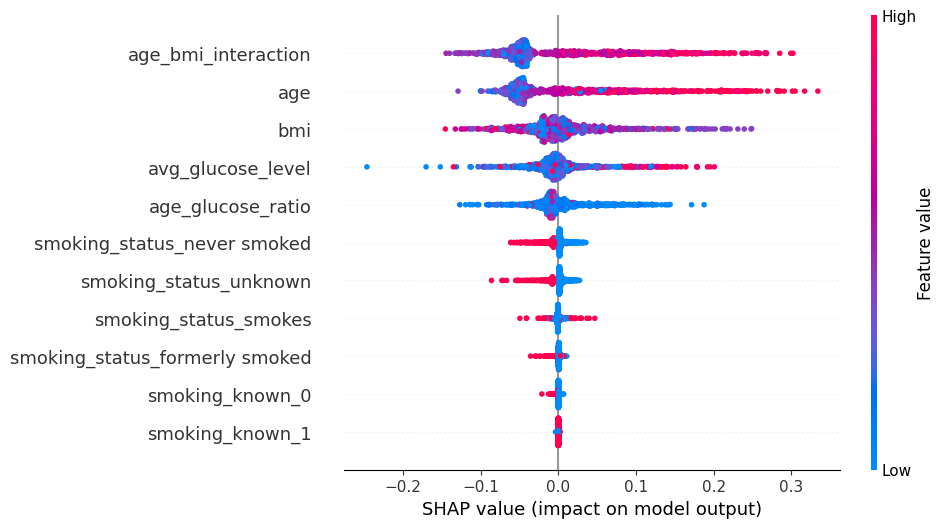

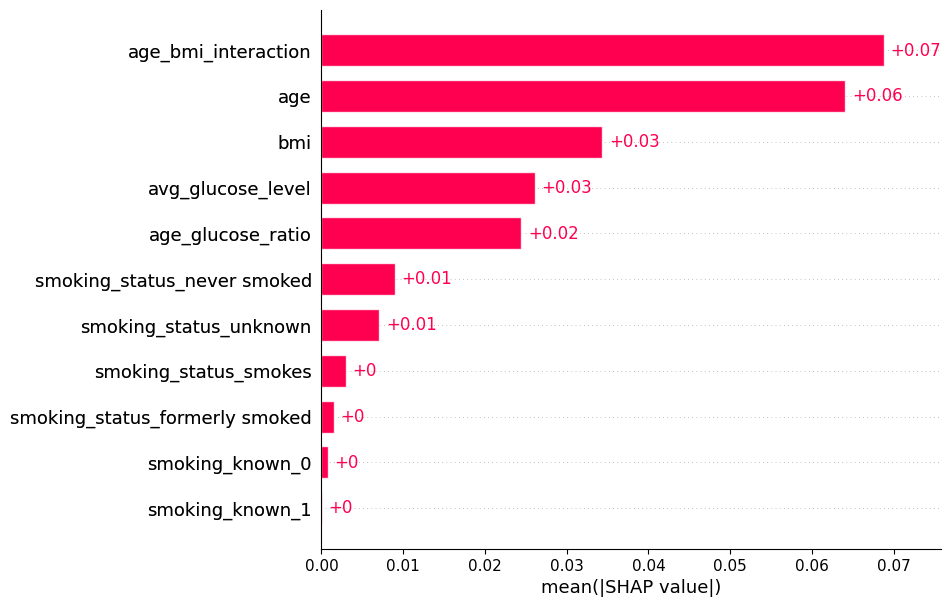

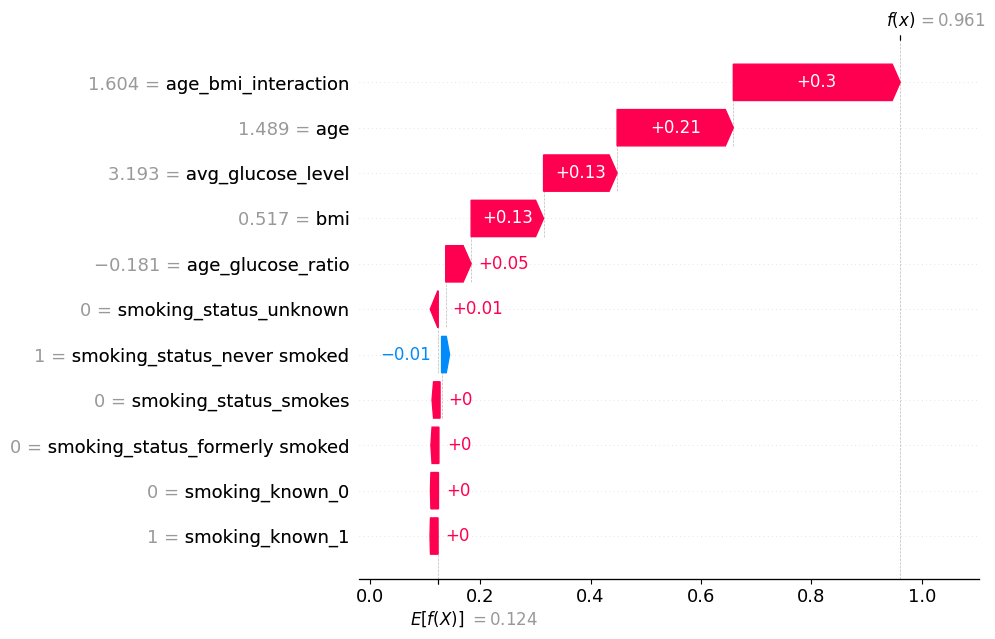

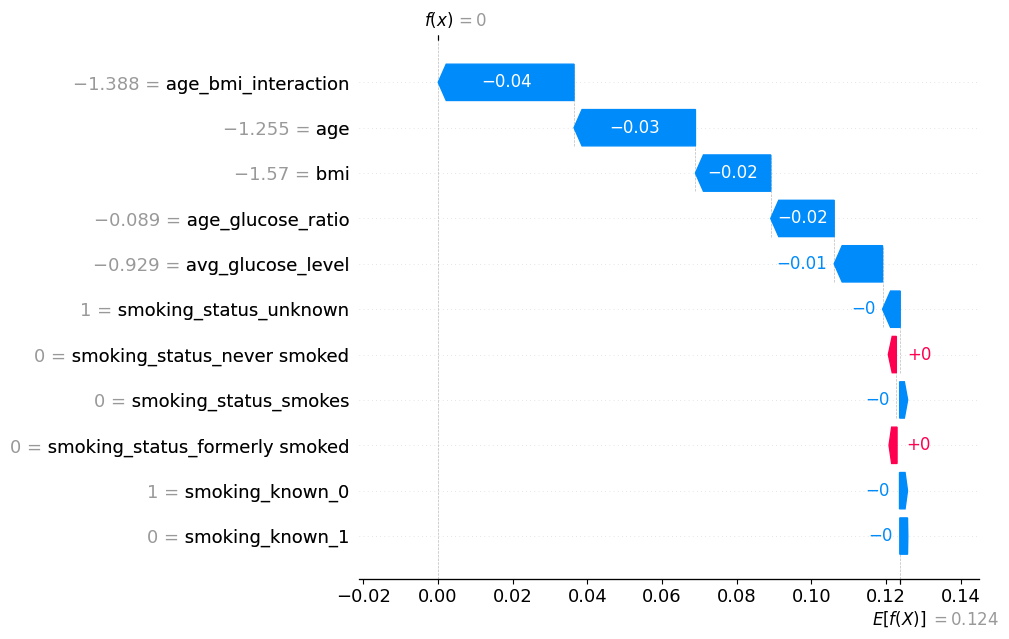

In [27]:
# === Cell 6 (ROBUST) — Permutation SHAP via function wrapper ===
import shap, numpy as np
shap.initjs()

# 1) Callable that takes ENCODED arrays and returns positive-class probs
f = lambda Xdense: xgb_tuned.named_steps["clf"].predict_proba(Xdense)[:, 1]

# 2) Small background set from ENCODED train for speed
rng = np.random.RandomState(42)
bg_idx = rng.choice(Xtr_enc.shape[0], size=min(500, Xtr_enc.shape[0]), replace=False)
background = Xtr_enc[bg_idx]

# 3) Build Explainer with permutation algorithm
explainer = shap.Explainer(f, background, algorithm="permutation", feature_names=feat_names)

# 4) Explain a manageable slice of the test set (to keep it fast)
sel = slice(0, min(1000, Xte_enc.shape[0]))   # adjust if you want all
ex = explainer(Xte_enc[sel])

# 5) Global importance
shap.plots.beeswarm(ex, max_display=15)
shap.plots.bar(ex, max_display=15)

# 6) Local explanations on two specific rows in that slice
probs_x = xgb_tuned.predict_proba(X_test)[:, 1]
hi_x = int(np.argmax(probs_x)); lo_x = int(np.argmin(probs_x))
# map absolute indices to the sel slice if needed:
def to_sel_idx(i): return i if (isinstance(sel, slice) and i < ex.values.shape[0]) else 0

shap.plots.waterfall(ex[to_sel_idx(hi_x)], max_display=15)
shap.plots.waterfall(ex[to_sel_idx(lo_x)], max_display=15)


In [20]:

import matplotlib.pyplot as plt, os
os.makedirs("../reports/figures", exist_ok=True)

# After each SHAP plot call, immediately save:
plt.savefig("../reports/figures/shap_beeswarm_xgb.png", dpi=300, bbox_inches="tight")
plt.close()

plt.savefig("../reports/figures/shap_bar_xgb.png", dpi=300, bbox_inches="tight")
plt.close()

plt.savefig("../reports/figures/shap_waterfall_high_xgb.png", dpi=300, bbox_inches="tight")
plt.close()

plt.savefig("../reports/figures/shap_waterfall_low_xgb.png", dpi=300, bbox_inches="tight")
plt.close()


In [21]:
import numpy as np, pandas as pd
vals = np.abs(ex.values).mean(axis=0)
top = (pd.DataFrame({"feature": ex.feature_names, "mean_abs_shap": vals})
         .sort_values("mean_abs_shap", ascending=False))
top.to_csv("../reports/top_shap_xgb.csv", index=False)
top.head(10)


,feature,mean_abs_shap
3,age_bmi_interaction,0.069118
0,age,0.063959
2,bmi,0.034395
1,avg_glucose_level,0.026084
4,age_glucose_ratio,0.024470
6,smoking_status_never smoked,0.008936
8,smoking_status_unknown,0.007085
7,smoking_status_smokes,0.002981
5,smoking_status_formerly smoked,0.001496
9,smoking_known_0,0.000741
